In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils_v2 import *

%matplotlib inline

In [2]:
aq_df4 = pd.read_csv('./data/aiqQuality_201804.csv')
grid_df4 = pd.read_csv('./data/gridWeather_201804.csv')
ob_df4 = pd.read_csv('./data/observedWeather_201804.csv')

In [3]:
len(grid_df4),len(ob_df4)

(463476, 12544)

In [4]:
ob_df4.head()

,id,station_id,time,weather,temperature,pressure,humidity,wind_speed,wind_direction
0,2028533,shunyi_meo,2018-04-01 01:00:00,Hail,15.5,1009.2,51.0,0.5,82.0
1,2028534,hadian_meo,2018-04-01 01:00:00,Hail,15.7,1006.8,51.0,1.8,50.0
2,2028535,yanqing_meo,2018-04-01 01:00:00,Hail,12.6,955.6,33.0,0.8,34.0
3,2028536,miyun_meo,2018-04-01 01:00:00,Hail,14.8,1004.0,40.0,0.2,999017.0
4,2028537,huairou_meo,2018-04-01 01:00:00,Hail,15.3,1003.4,44.0,1.5,146.0


In [5]:
#prepare weather data
weather_all = pd.concat([ob_df4,grid_df4]).reset_index()
weather_all = clean_weather(weather_all)


In [6]:
#get_aq_w_dist().nth(1)

In [7]:
#add time columns to airQuality data
#levels is the number of nearest weather station to search
#time_column is the name of the time column
aq_all = fill_weather_gap(aq_df=aq_df4,weather_df=weather_all,levels = 5,time_column = 'time')


aq_all['timestamp'] = pd.to_datetime(aq_all['time'])
aq_all['year'] = aq_all['timestamp'].dt.year
aq_all['month'] = aq_all['timestamp'].dt.month
aq_all['day'] = aq_all['timestamp'].dt.day
aq_all['hour'] = aq_all['timestamp'].dt.hour



Level 1 #null before 353
After:  104
Level 2 #null before 104
After:  66
Level 3 #null before 66
After:  48
Level 4 #null before 48
After:  30


In [8]:
#TODO:predict aq loss value
aq_all = aq_all.fillna(method='ffill')

#add geo info of the air quality stations for nearest weather station searching
aq_geo = pd.read_csv('./data/aq_geo.csv')
aq_all = aq_all.merge(aq_geo,how='left',on='station_id')

In [9]:
aq_all.columns

Index(['id', 'time', 'PM25_Concentration', 'PM10_Concentration',
       'NO2_Concentration', 'CO_Concentration', 'O3_Concentration',
       'SO2_Concentration', 'dist', 'w_end', 'pressure', 'temperature',
       'humidity', 'weather', 'wind_direction', 'wind_speed', 'station_id',
       'timestamp', 'year', 'month', 'day', 'hour', 'longitude', 'latitude',
       'station_type_id'],
      dtype='object')

### Prepare data for feature extraction
先把原始的三周的数据拿出来，以便于之后的算statistical features

In [10]:
time_columns = ['year','month','day','hour']
attrs_to_predict = ['PM25_Concentration', 'PM10_Concentration', 'O3_Concentration']
weather_attrs  = ['pressure','temperature','humidity','wind_direction','wind_speed']
timestamp_column_name = 'time'

#result will be numpy array in the format (station_id,station_type_id,time_columns,historical_data-> 24*7*3 * 3,to_be_predicted_values)
data_201804 = get_raw_train_test_data(aq_all,attrs_to_predict,time_columns,timestamp_column_name,weather_attrs,24*7*3)

data_201804 = np.array(data_201804)

In [11]:
aq_all.columns

Index(['id', 'time', 'PM25_Concentration', 'PM10_Concentration',
       'NO2_Concentration', 'CO_Concentration', 'O3_Concentration',
       'SO2_Concentration', 'dist', 'w_end', 'pressure', 'temperature',
       'humidity', 'weather', 'wind_direction', 'wind_speed', 'station_id',
       'timestamp', 'year', 'month', 'day', 'hour', 'longitude', 'latitude',
       'station_type_id'],
      dtype='object')

In [12]:
data_201804.shape

(3990, 2142)

### Extract features from the raw historical data
根据前面准备的前三周数据取statistical features，还有取holiday feature
只取最后48小时作为测试集

In [13]:
#1.split the data in april into training and validation part
#Use the data on 4.29 as validation and others for training
data_201804_train = data_201804[np.where((data_201804[:,4] != '29') | (data_201804[:,5] != '21'))]
data_201804_val = data_201804[np.where((data_201804[:,4] == '29') & (data_201804[:,5] == '21'))]
data_201804_train.shape,data_201804_val.shape,data_201804.shape

((3955, 2142), (35, 2142), (3990, 2142))

In [16]:
#存起来备用
np.save('mnt/disks/bdt/201804_train_x.npy',train_x)
np.save('mnt/disks/bdt/201805_train_y.npy',train_y)
np.save('mnt/disks/bdt/201804_val_x.npy',val_x)
np.save('mnt/disks/bdt/201805_val_y.npy',val_y)

In [4]:
ob_df_test= pd.read_csv('data/observedWeather_20180501-20180502.csv')
grid_df_test = pd.read_csv('data/gridWeather_20180501-20180502.csv')

这里依次训练三个模型
参数并非search出来的结果，只是参照别人的调参经验试用的一些参数
不使用sklearn接口

In [21]:
import lightgbm
targets = [ 'PM25_Concentration', 'PM10_Concentration', 'O3_Concentration']
models ={}
for i in targets:
    print(i)
    X_raw_train,y_raw_train = split_features_labels(data = data_201804_train,attr =i,length = 24*7*3)
    X_raw_val,y_raw_val = split_features_labels(data = data_201804_val,attr =i,length = 24*7*3)

    X_raw_train = X_raw_train.astype(np.float)
    y_raw_train = y_raw_train.astype(np.float)
    X_raw_val = X_raw_val.astype(np.float)
    y_raw_val = y_raw_val.astype(np.float)
    train_201804 = get_train_data_final(X_raw_train,y_raw_train)
    train_201804 = np.vstack(train_201804)
    train_x = train_201804[:,:-1]
    train_y = train_201804[:,-1]

    val_201804 = get_train_data_final(X_raw_val,y_raw_val)
    val_201804 = np.vstack(val_201804)
    val_x = val_201804[:,:-1]
    val_y = val_201804[:,-1]
    train = lightgbm.Dataset(train_x,train_y)
    val = lightgbm.Dataset(val_x,val_y)
    params = {  
        'boosting_type': 'gbdt',  
        'objective': 'mse',  
        'metric': {'mse'},  
        #'num_leaves':1000,  
        'max_depth': 10,  
        #'min_data_in_leaf': 450,  
        'learning_rate': 0.1,  
        'feature_fraction': 0.9,  
        'bagging_fraction': 0.95,  
        #'bagging_freq': 5,  
        #'lambda_l1': 1,    
        'lambda_l2': 0.01,  # 越小l2正则程度越高  
        #'min_gain_to_split': 0.2,  
        'verbose': 0,
    }  
    models[i] = lightgbm.train(params,train,num_boost_round = 1000)#,valid_sets=[train,val],valid_names = ['train','val']
    import evaluation
    import sklearn
    result = models[i].predict(val_x)
    print(evaluation.smape(result,val_y))
    print(sklearn.metrics.mean_squared_error(result,val_y))

PM25_Concentration


C:\Users\Wangzhc\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 2 results
  r = func(a, **kwargs)


PM25_Concentration
PM2.5
PM25_Concentration
PM2.5
0.33681834989718995
8870.143693016142
PM10_Concentration
PM10_Concentration
PM10_Concentration
0.4448346183949107
1537.6304240497739
O3_Concentration
O3_Concentration
O3_Concentration
0.36813020132001373
946.1152937715352


0.34190792591120167
9311.514047390006


In [50]:
print(evaluation.smape(result,val_y))

0.5435896236594118


In [54]:
train_x[-1,35:45]

array([1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       2.0180000e+03, 4.0000000e+00, 2.9000000e+01, 2.0000000e+01,
       1.0041375e+03, 1.7000000e+01])

In [56]:
val_x[-1 ,35:45]

array([1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       2.018000e+03, 4.000000e+00, 2.900000e+01, 2.100000e+01,
       9.974287e+02, 1.500000e+01])

In [22]:
plt.figure(figsize=(400,400))
lightgbm.plot_importance(model[0], max_num_features=20)
plt.show()

NameError: name 'model' is not defined

In [48]:
val_x[0:200,690]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47.,  0.,  1.,  2.,  3.,
        4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
       17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.,
       30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
        8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.,
       21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33.,
       34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46.,
       47.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
       25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36

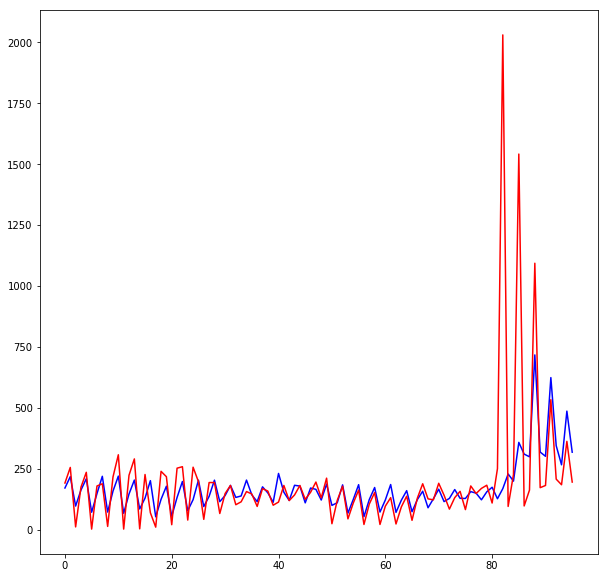

In [69]:
a = list(result.reshape(-1)[0:96])
b = list(val_y.reshape(-1)[0:96])
plt.figure(figsize=(10,10))
plt.plot(a,'b')
plt.plot(b,'r')
plt.show()

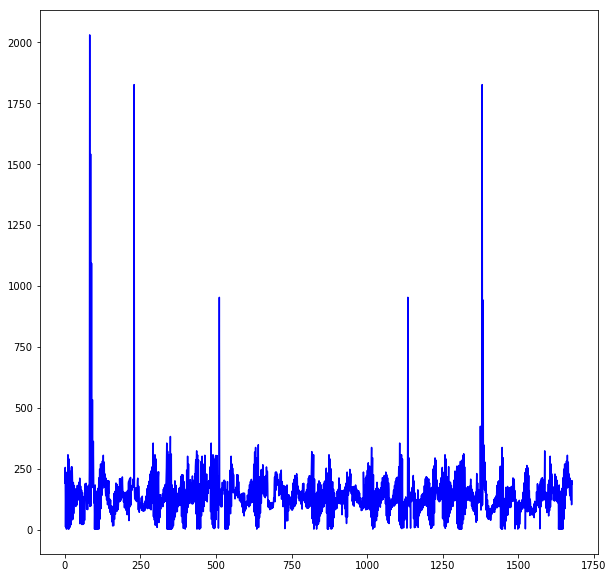

In [70]:
plt.figure(figsize=(10,10))
plt.plot(val_y,'b')
plt.show()